### Training the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

train_data = pd.read_csv("Arabic Handwritten Digits Dataset/TrainImages 60k x 784.csv")
test_data = pd.read_csv("Arabic Handwritten Digits Dataset/TestImages 10k x 784.csv")

Y_train = pd.read_csv("Arabic Handwritten Digits Dataset/TrainLabel 60k x 1.csv")
digits_target = Y_train.T.iloc[0,:]
X_train = train_data
X_train = X_train / 255.0
X_test = test_data / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1)

datagen.fit(X_train)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

model = Sequential()

model.add(Conv2D(32, kernel_size=5,input_shape=(28, 28, 1), activation = 'relu'))
model.add(Conv2D(32, kernel_size=5, activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size=3,activation = 'relu'))
model.add(Conv2D(64, kernel_size=3,activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=3, activation = 'relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

optimizer=Adam(lr=0.001)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
model_try = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=32),
                              epochs = 30, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=300, callbacks=[annealer])
                              
predictions = model.predict(X_test)
predictions = np.argmax(predictions,axis = 1)
predictions = pd.Series(predictions, name="Label")
submit = pd.concat([pd.Series(range(1,28001),name = "ImageId"),predictions],axis = 1)
submit.to_csv("ArabicResults.csv",index=False)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          36928     
__________

In [3]:
scores = model.evaluate(X_val, Y_val, verbose=0)
print("Training Accuracy: %.2f%%" % (scores[1]*100))
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Training Accuracy: 99.52%
CNN Error: 0.48%


# Start here if you want to skip the training part

### Loading the model from the file

In [4]:
from keras.models import load_model 
model=load_model('ArabicDigits_deeplearn.h5')

Predicted:  [2]


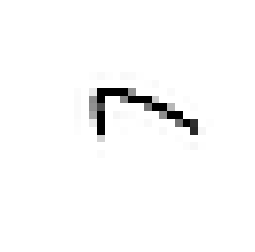

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import cv2
from PIL import Image
import numpy as np

def imageprepare(argv):
    """
    This function returns the pixel values.
    The input is a png file location.
    """
    im = Image.open(argv).convert("RGB")
    im = im.convert("L")

    width = float(im.size[0])
    height = float(im.size[1])
    new_image = Image.new('L', (28, 28), 255)  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if nheight == 0:  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        new_image.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Height becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if nwidth == 0:  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        new_image.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(new_image.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    return tva


def remove_transparent(path):
    im = Image.open(path).convert("RGBA")
    width = float(im.size[0])
    height = float(im.size[1])
    canvas = Image.new('RGBA', im.size, (255, 255, 255, 255))  # Empty canvas colour (r,g,b,a)
    canvas.paste(im, mask=im)  # Paste the image onto the canvas, using it's alpha channel as mask
    canvas.thumbnail([width, height], Image.ANTIALIAS)
    canvas.save(path, format="PNG")

def convert_image(image_path):
    remove_transparent(image_path)
    x = [imageprepare(image_path)]  # file path here
    # Now we convert 784 sized 1d array to 24x24 sized 2d array so that we can visualize it
    new_arr = [[0 for d in range(28)] for y in range(28)]
    k = 0
    for i in range(28):
        for j in range(28):
            new_arr[i][j] = x[0][k]
            k = k + 1

    return new_arr

new_img=convert_image('C:/xampp/htdocs/digit_recog/tmp/img.png')
plt.subplot(1, 1, 1)
plt.axis('off')
plt.imshow(new_img, cmap=plt.cm.gray_r, interpolation='nearest')
npimg=np.array(new_img)
npimg[npimg>0.1]=1
npimg[npimg<=0.1]=0
npimg=npimg.reshape(-1,28,28,1)
predicted = model.predict(npimg)
predicted = np.argmax(predicted,axis = 1)
print("Predicted: ",predicted)

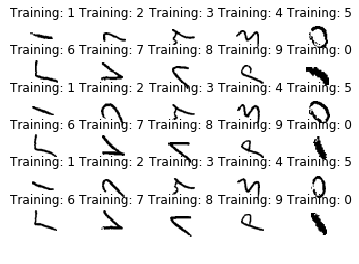

In [6]:
digits_images=train_data.apply(lambda x: np.reshape(x.values,(28,28)),axis=1)
digits_images=np.asarray(digits_images.tolist())

Y_train = pd.read_csv("Arabic Handwritten Digits Dataset/TrainLabel 60k x 1.csv")
digits_target = Y_train
digits_target = digits_target.T.iloc[0,:]

images_and_targets = list(zip(digits_images, digits_target))
for index, (image, target) in enumerate(images_and_targets[:30]):
    plt.subplot(6, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' %int(target))